In [1]:
import sys
import os

module_path = os.path.abspath(os.pardir)
if module_path not in sys.path:
    sys.path.append(module_path)
from src import choose_day_number, search_best_params, predict_best_model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBRegressor

### Pollutants

In this section we can see polluntants plots and check outliers, if any.

In [46]:
country = 'LV'

In [91]:
df_co = pd.read_csv(f"../data/interim/cleaned/{country}_CO_cleaned.csv", parse_dates=['Datetime'], index_col=['Datetime'])
df_co

,Countrycode,Namespace,AirQualityNetwork,AirQualityStation,AirQualityStationEoICode,SamplingPoint,SamplingProcess,Sample,AirPollutant,AirPollutantCode,AveragingTime,Concentration,UnitOfMeasurement,DatetimeBegin,DatetimeEnd,Validity,Verification
Datetime,,,,,,,,,,,,,,,,,
2020-01-01 01:00:00+01:00,LV,LV.LEGMC.AQ,NET-LV002A,STA-LV000L1,LV0012A,SPO-LV000L1_00010_100,SPP-LV000L1_00010_100_CO_automatic_NDIR_horiba...,SAM-LV000L1_00010_100_100,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.22,mg/m3,2020-01-01 00:00:00 +01:00,2020-01-01 01:00:00 +01:00,1,1
2020-01-01 02:00:00+01:00,LV,LV.LEGMC.AQ,NET-LV002A,STA-LV000L1,LV0012A,SPO-LV000L1_00010_100,SPP-LV000L1_00010_100_CO_automatic_NDIR_horiba...,SAM-LV000L1_00010_100_100,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.19,mg/m3,2020-01-01 01:00:00 +01:00,2020-01-01 02:00:00 +01:00,1,1
2020-01-01 03:00:00+01:00,LV,LV.LEGMC.AQ,NET-LV002A,STA-LV000L1,LV0012A,SPO-LV000L1_00010_100,SPP-LV000L1_00010_100_CO_automatic_NDIR_horiba...,SAM-LV000L1_00010_100_100,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.16,mg/m3,2020-01-01 02:00:00 +01:00,2020-01-01 03:00:00 +01:00,1,1
2020-01-01 04:00:00+01:00,LV,LV.LEGMC.AQ,NET-LV002A,STA-LV000L1,LV0012A,SPO-LV000L1_00010_100,SPP-LV000L1_00010_100_CO_automatic_NDIR_horiba...,SAM-LV000L1_00010_100_100,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.16,mg/m3,2020-01-01 03:00:00 +01:00,2020-01-01 04:00:00 +01:00,1,1
2020-01-01 05:00:00+01:00,LV,LV.LEGMC.AQ,NET-LV002A,STA-LV000L1,LV0012A,SPO-LV000L1_00010_100,SPP-LV000L1_00010_100_CO_automatic_NDIR_horiba...,SAM-LV000L1_00010_100_100,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.15,mg/m3,2020-01-01 04:00:00 +01:00,2020-01-01 05:00:00 +01:00,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-06 07:00:00+01:00,LV,LV.LEGMC.AQ,NET-LV002A,STA-LV000L1,LV0012A,SPO-LV000L1_00010_100,SPP-LV_A_DOAS_opsisAR500/ER150,NaN,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.24,mg/m3,2021-01-06 06:00:00 +01:00,2021-01-06 07:00:00 +01:00,1,3
2021-01-06 08:00:00+01:00,LV,LV.LEGMC.AQ,NET-LV002A,STA-LV000L1,LV0012A,SPO-LV000L1_00010_100,SPP-LV_A_DOAS_opsisAR500/ER150,NaN,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.26,mg/m3,2021-01-06 07:00:00 +01:00,2021-01-06 08:00:00 +01:00,1,3
2021-01-06 09:00:00+01:00,LV,LV.LEGMC.AQ,NET-LV002A,STA-LV000L1,LV0012A,SPO-LV000L1_00010_100,SPP-LV_A_DOAS_opsisAR500/ER150,NaN,CO,http://dd.eionet.europa.eu/vocabulary/aq/pollu...,hour,0.29,mg/m3,2021-01-06 08:00:00 +01:00,2021-01-06 09:00:00 +01:00,1,3


<AxesSubplot:xlabel='Datetime'>

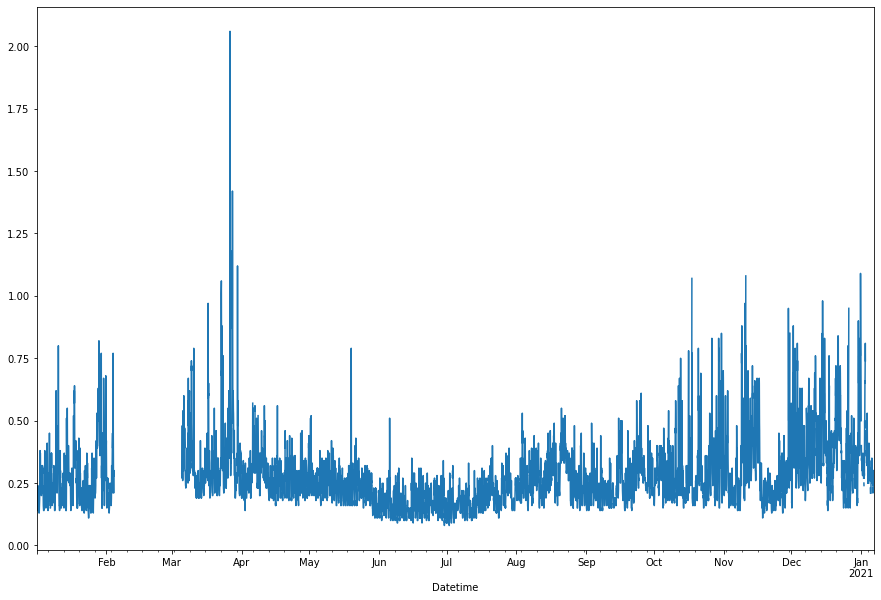

In [92]:
fig = plt.figure(figsize=(15, 10))
df_co["Concentration"].plot()

<AxesSubplot:xlabel='Datetime'>

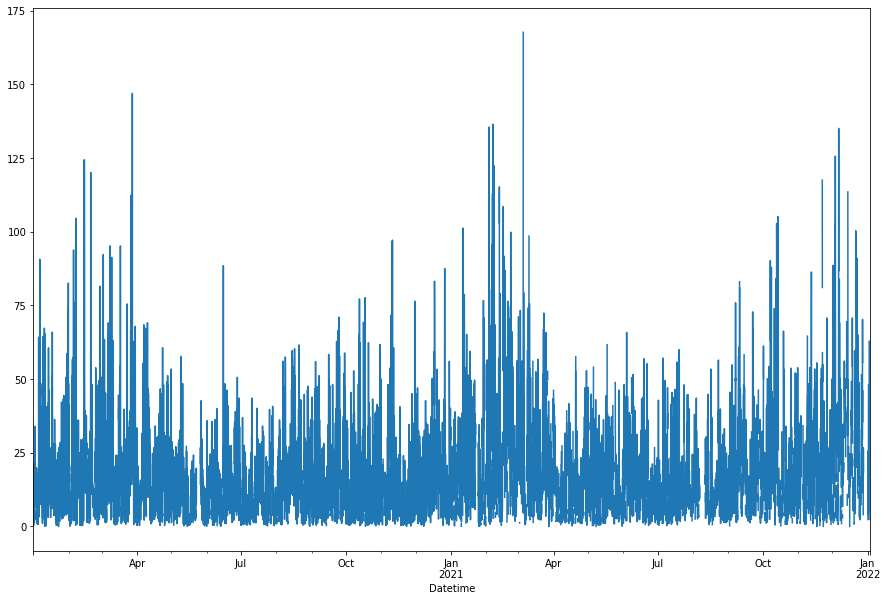

In [93]:
df_no2 = pd.read_csv(f"../data/interim/cleaned/{country}_NO2_cleaned.csv", parse_dates=['Datetime'], index_col=['Datetime'])
fig = plt.figure(figsize=(15, 10))
df_no2["Concentration"].plot()

<AxesSubplot:xlabel='Datetime'>

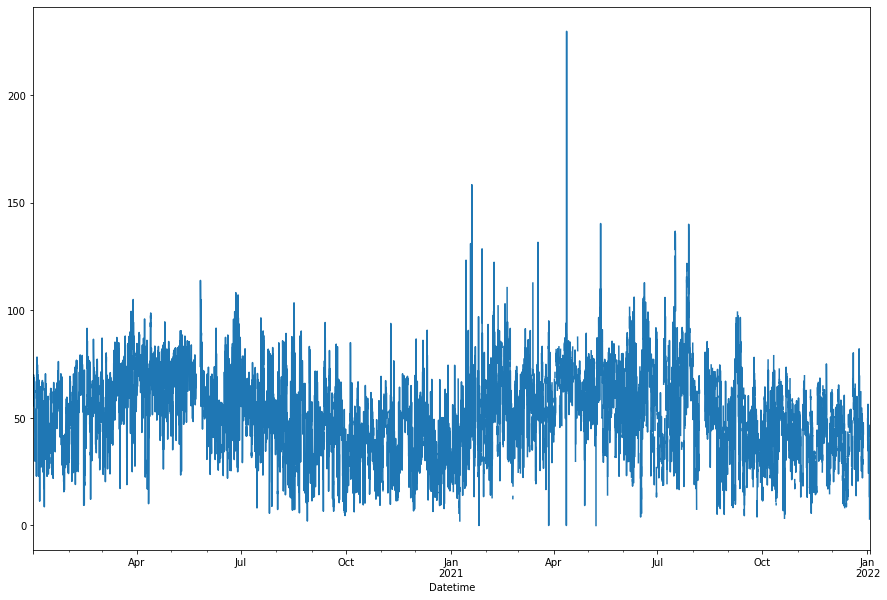

In [94]:
df_o3 = pd.read_csv(f"../data/interim/cleaned/{country}_O3_cleaned.csv", parse_dates=['Datetime'], index_col=['Datetime'])
fig = plt.figure(figsize=(15, 10))
df_o3["Concentration"].plot()

<AxesSubplot:xlabel='Datetime'>

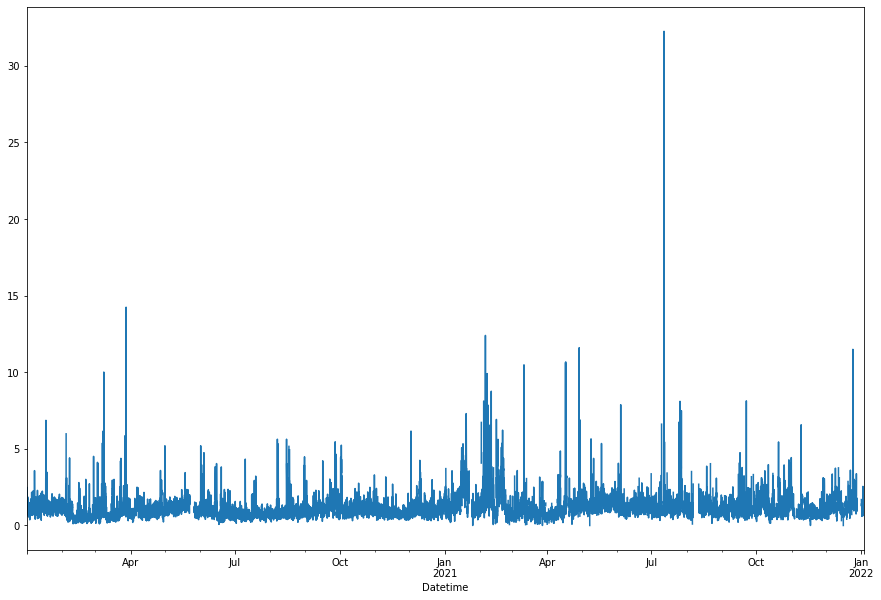

In [95]:
df_so2 = pd.read_csv(f"../data/interim/cleaned/{country}_SO2_cleaned.csv", parse_dates=['Datetime'], index_col=['Datetime'])
fig = plt.figure(figsize=(15, 10))
df_so2["Concentration"].plot()

There are many big values for PM10 and PM2.5. But we have to remember that its values can be above 500.

<AxesSubplot:xlabel='Datetime'>

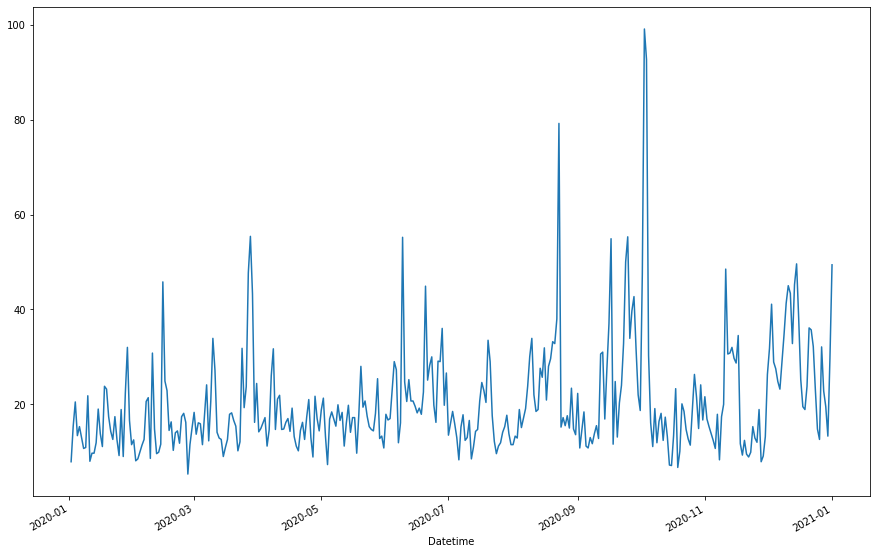

In [99]:
df_pm10 = pd.read_csv(f"../data/interim/cleaned/{country}_PM10_cleaned.csv", parse_dates=['Datetime'], index_col=['Datetime'])
fig = plt.figure(figsize=(15, 10))
df_pm10["Concentration"].dropna().plot()

<AxesSubplot:xlabel='Datetime'>

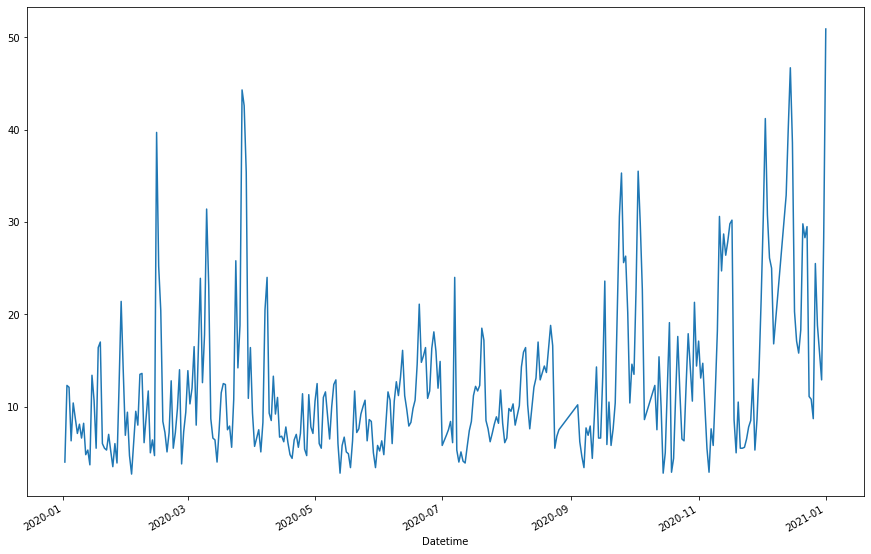

In [97]:
df_pm25 = pd.read_csv(f"../data/interim/cleaned/{country}_PM2.5_cleaned.csv", parse_dates=['Datetime'], index_col=['Datetime'])
fig = plt.figure(figsize=(15, 10))
df_pm25["Concentration"].dropna().plot()

### AQI

AQI - air quality index is the highest value calculated for each pollutant. For polutants are calculated subindex and then we choose the biggest one. 

It's AQI for 1 hour

<AxesSubplot:xlabel='Datetime'>

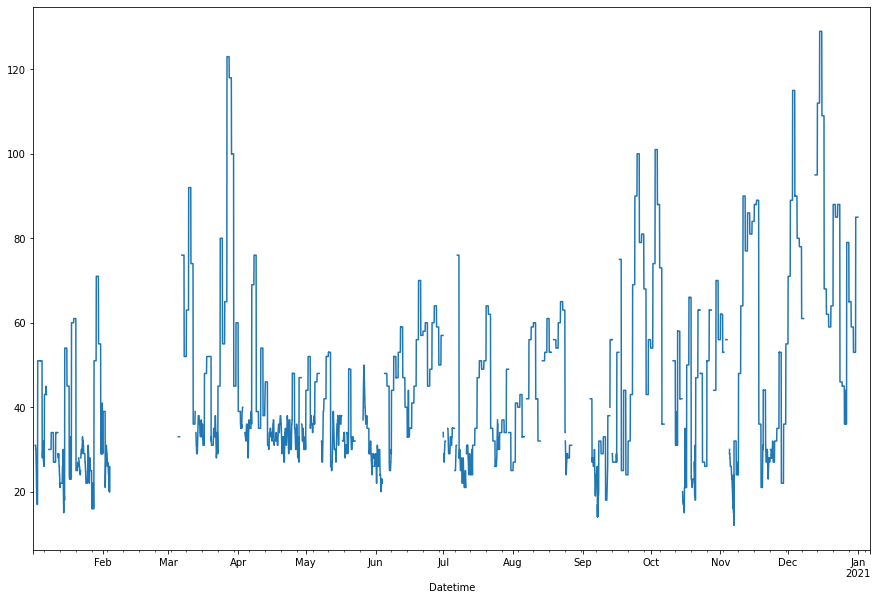

In [100]:
df_aqi = pd.read_csv("../data/processed/AQI_dataset.csv", parse_dates=['Datetime'], index_col=['Datetime'])
fig = plt.figure(figsize=(15, 10))
df_aqi["AQI"].plot()

We use daily AQI

<AxesSubplot:xlabel='Datetime'>

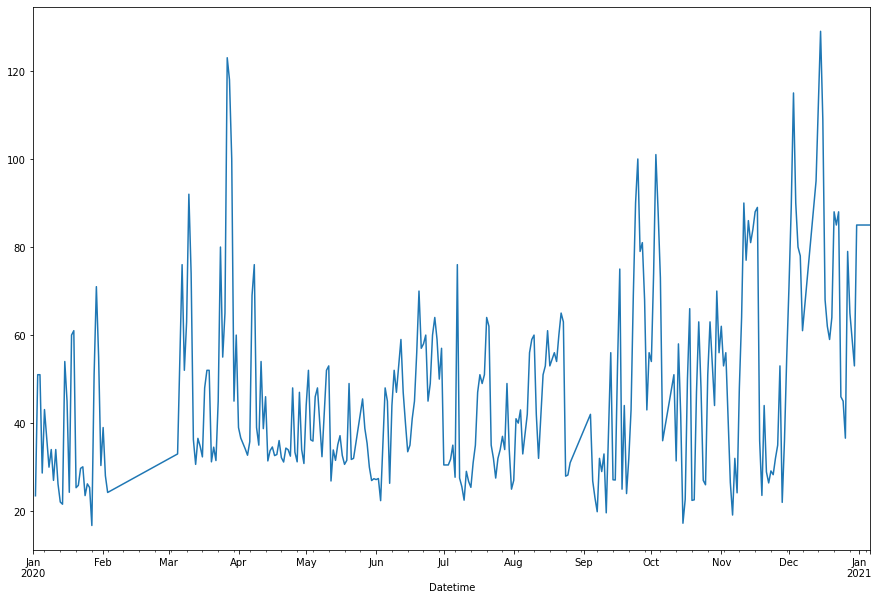

In [101]:
df_aqi_daily = df_aqi.resample('D').mean().interpolate()
fig = plt.figure(figsize=(15, 10))
df_aqi_daily["AQI"].plot()

<AxesSubplot:xlabel='Datetime'>

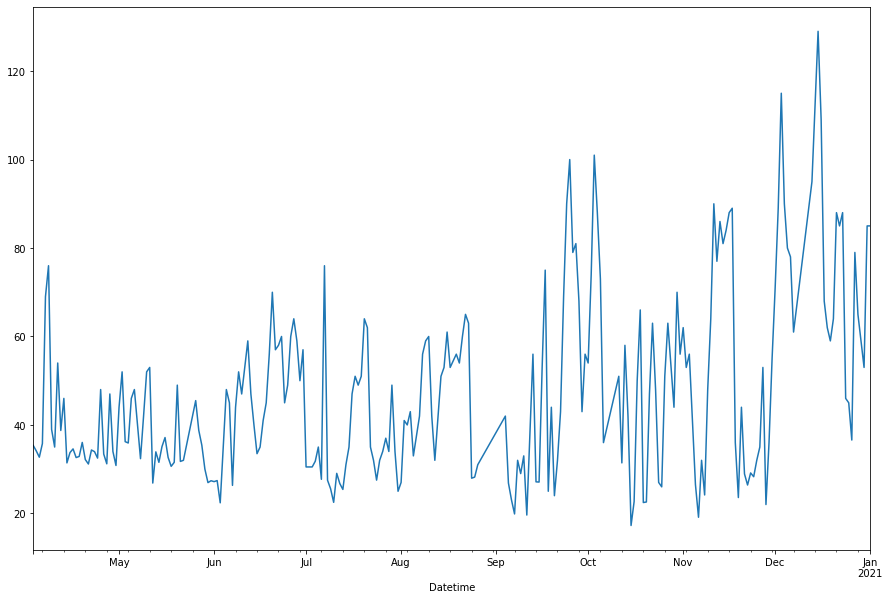

In [103]:
df_aqi_daily = df_aqi_daily.loc["2020-04-03 00:00:00+01:00":"2021-01-01 00:00:00+01:00"]
fig = plt.figure(figsize=(15, 10))
df_aqi_daily["AQI"].plot()

***Time series analysis***

Stationarity

In [104]:
ADF_result = adfuller(df_aqi_daily["AQI"])   
print(f'ADF Statistic: {ADF_result[0]}') 
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.2593632589068084
p-value: 4.260604262823911e-08


With a large negative ADF statistic and a p-value much smaller than 0.05, we can say that our series is stationary.

Autocorrelation

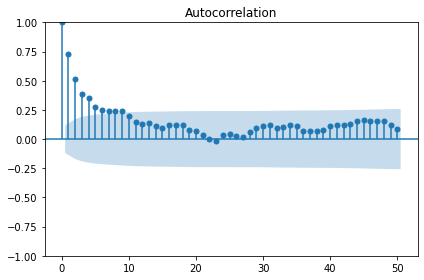

In [105]:
plot_acf(df_aqi_daily["AQI"], lags=50)
plt.tight_layout()

Significant autocorrelation for 6 lags (but some pick we see later)

C:\Users\nikit\AppData\Local\pypoetry\Cache\virtualenvs\mlops-project-yU0lcWq_-py3.9\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


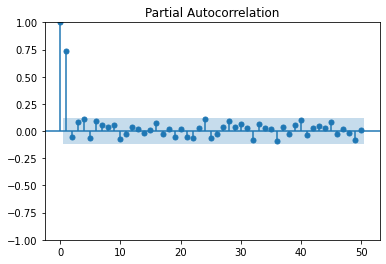

In [106]:
plot_pacf(df_aqi_daily["AQI"], lags=50)
plt.show()

1 significant lag

Looks like autoregressive process 

<AxesSubplot:xlabel='Datetime'>

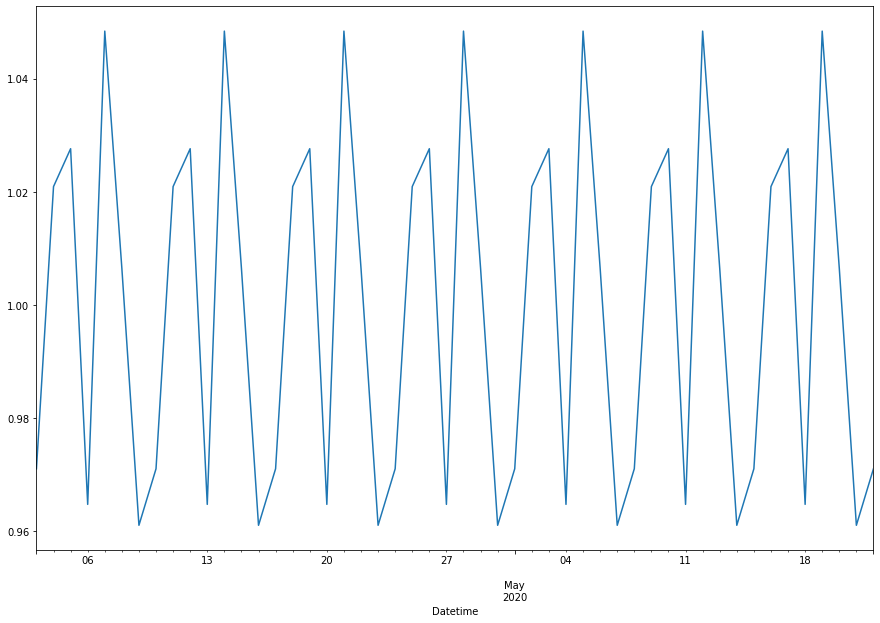

In [107]:
analysis = df_aqi_daily["AQI"].copy()


decompose_result_mult = seasonal_decompose(analysis, model="multiplicative")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

fig = plt.figure(figsize=(15, 10))
seasonal[:50].plot()

Looks like there is weekly seasonality

In [108]:
print("Mean: ", df_aqi_daily["AQI"].mean(), "\nSTD: ", df_aqi_daily["AQI"].std(), "\nMedian: ", df_aqi_daily["AQI"].median())

Mean:  47.6983932611954 
STD:  20.274605052969864 
Median:  42.0625


<AxesSubplot:ylabel='AQI'>

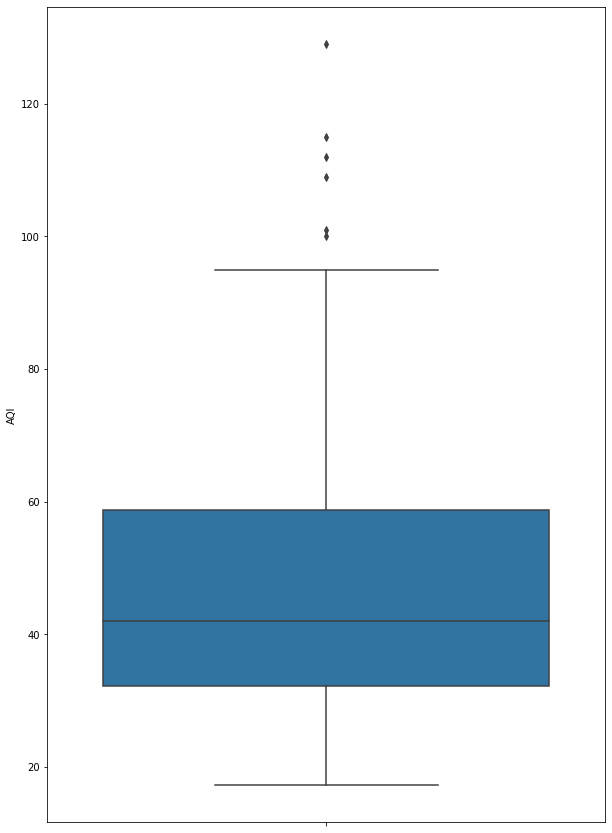

In [109]:
fig = plt.figure(figsize=(10, 15))
sns.boxplot(y=df_aqi_daily["AQI"])

### ***Baseline Naive Algorithm***

In [110]:
pd.concat([df_aqi_daily["AQI"].shift(1), df_aqi_daily["AQI"]], axis=1).dropna()

,AQI,AQI
Datetime,,
2020-04-04 00:00:00+01:00,35.375000,34.125000
2020-04-05 00:00:00+01:00,34.125000,32.708333
2020-04-06 00:00:00+01:00,32.708333,35.791667
2020-04-07 00:00:00+01:00,35.791667,69.000000
2020-04-08 00:00:00+01:00,69.000000,76.000000
...,...,...
2020-12-28 00:00:00+01:00,79.000000,65.000000
2020-12-29 00:00:00+01:00,65.000000,59.000000
2020-12-30 00:00:00+01:00,59.000000,53.000000


In [111]:
values = pd.DataFrame(df_aqi_daily["AQI"].values)
df_naive = pd.concat([values.shift(1), values], axis=1).dropna()
df_naive.columns = ['t-1', 't+1']
df_naive

,t-1,t+1
1,35.375000,34.125000
2,34.125000,32.708333
3,32.708333,35.791667
4,35.791667,69.000000
5,69.000000,76.000000
...,...,...
269,79.000000,65.000000
270,65.000000,59.000000
271,59.000000,53.000000
272,53.000000,85.000000


For 5 days Naive

In [128]:
train, test = df_naive[1:-5], df_naive[-5:]
train_X, train_y = train["t-1"], train["t+1"]
test_X, test_y = test["t-1"], test["t+1"]

In [129]:
predictions = test_X.apply(lambda x: x)
test_rmse = mean_squared_error(test_y, predictions, squared=False)
test_mae = mean_absolute_error(test_y, predictions)
print("Test RMSE: %.3f" % test_rmse, "\nTest MAE: %.3f" % test_mae)

Test RMSE: 16.075 
Test MAE: 11.600


For 20% test size

In [114]:
train_size = int(df_naive.shape[0] * 0.75)
train, test = df_naive[1:train_size], df_naive[train_size:]
train_X, train_y = train["t-1"], train["t+1"]
test_X, test_y = test["t-1"], test["t+1"]

In [115]:
predictions = test_X.apply(lambda x: x)
test_rmse = mean_squared_error(test_y, predictions, squared=False)
test_mae = mean_absolute_error(test_y, predictions)
print("Test RMSE: %.3f" % test_rmse, "\nTest MAE: %.3f" % test_mae)

Test RMSE: 17.308 
Test MAE: 13.159


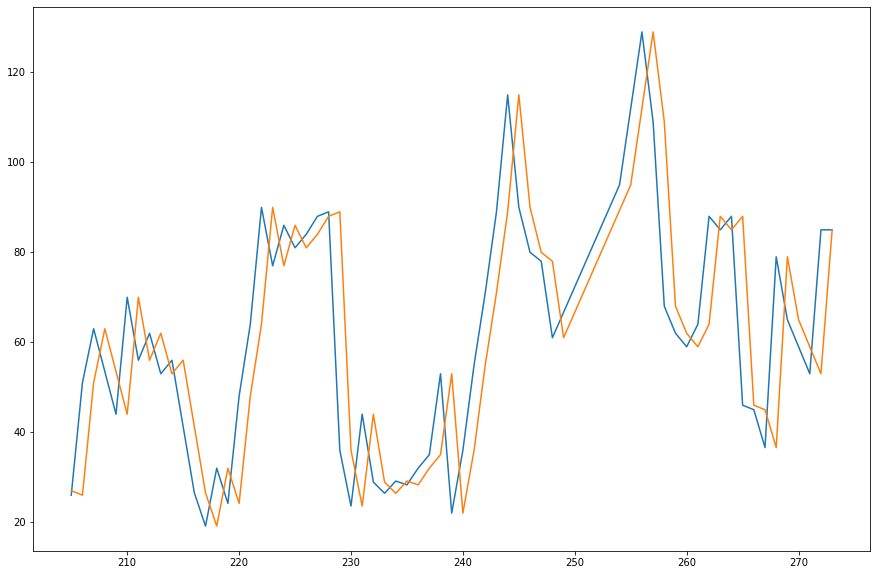

In [116]:
fig = plt.figure(figsize=(15, 10))
plt.plot(test_y.iloc[:])
plt.plot(predictions[:])
plt.show()

### ***SARIMA***

In [5]:
train, test = train_test_split(df_aqi_daily["AQI"], test_size=0.2, shuffle=False) 

In [122]:
aqi = df_aqi_daily["AQI"]

In [123]:
model = SARIMAX(aqi.iloc[:-5], order=(2,0,0), seasonal_order=(1,1,1,7))
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 AQI   No. Observations:                  269
Model:             SARIMAX(2, 0, 0)x(1, 1, [1], 7)   Log Likelihood               -1067.126
Date:                             Sun, 12 Jun 2022   AIC                           2144.253
Time:                                     13:05:43   BIC                           2162.095
Sample:                                 04-03-2020   HQIC                          2151.424
                                      - 12-27-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7702      0.055     13.924      0.000       0.662       0.879
ar.L2         -0.0867      

In [126]:
predictions_sarima = model_fit.predict(start=len(aqi), end=len(aqi)+4)

In [127]:
arima_test_rmse = mean_squared_error(aqi.iloc[-5:], predictions_sarima, squared=False)
arima_test_mae = mean_absolute_error(aqi.iloc[-5:], predictions_sarima)
print("Test RMSE: %.3f" % arima_test_rmse, "\nTest MAE: %.3f" % arima_test_mae)

Test RMSE: 13.338 
Test MAE: 12.002


### ***Random Forest***


For forest models we can use one day before feature or several day before target day, so lets see how many days we can use.

In [130]:
n = 30
col_aqi = ["AQI"]
cols_pollutant = [x for x in df_aqi_daily.columns if 'avg' in x]

In [131]:
error_dict = choose_day_number(col_aqi, df_aqi_daily, n, RandomForestRegressor(random_state=0))

May be we can use concentration instead of index

In [132]:
error_dict_pollutant = choose_day_number(cols_pollutant, df_aqi_daily, n, RandomForestRegressor(random_state=0))

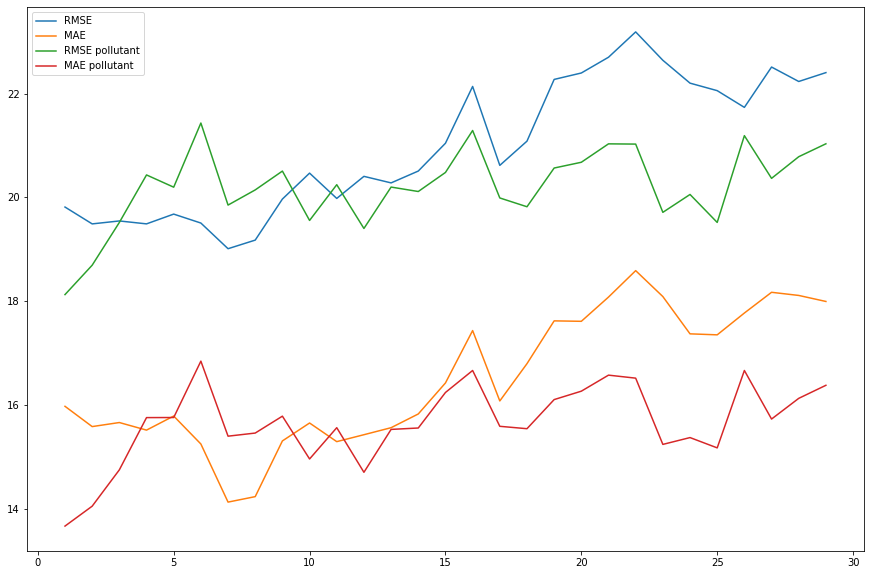

In [133]:
fig = plt.figure(figsize=(15, 10))
plt.plot([i for i in range(1, n)], error_dict["rmse"], label="RMSE")
plt.plot([i for i in range(1, n)], error_dict["mae"], label="MAE")
plt.plot([i for i in range(1, n)], error_dict_pollutant["rmse"], label="RMSE pollutant")
plt.plot([i for i in range(1, n)], error_dict_pollutant["mae"], label="MAE pollutant")
plt.legend()
plt.show()

Now we will be use this dataset for search hyperparameters

In [134]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 15)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 15)]
max_depth.append(None)
min_samples_split = [2, 5, 8, 10]
min_samples_leaf = [2, 4, 6, 8]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [135]:
depth = 1
best_rf = search_best_params(cols_pollutant, df_aqi_daily, depth, 3, random_grid, RandomForestRegressor(random_state=0))
best_rf.best_params_

{'n_estimators': 1871,
 'min_samples_split': 5,
 'min_samples_leaf': 8,
 'max_depth': 60,
 'bootstrap': True}

In [136]:
rmse_rf, mae_rf = predict_best_model(df_aqi_daily, cols_pollutant, depth, RandomForestRegressor(random_state=0, **best_rf.best_params_))
print("Test RMSE: %.3f" % rmse_rf, "\nTest MAE: %.3f" % mae_rf)

Test RMSE: 20.734 
Test MAE: 15.847


In [137]:
col_aqi = ["AQI"]
error_xgb = choose_day_number(col_aqi, df_aqi_daily, n, XGBRegressor(random_state=0))

In [138]:
cols_pollutant = ['CO_avg', 'PM10_avg', 'NO2_avg', 'SO2_avg', 'O3_avg', 'PM2.5_avg']
error_xgb_pollutant = choose_day_number(cols_pollutant, df_aqi_daily, n, XGBRegressor(random_state=0))

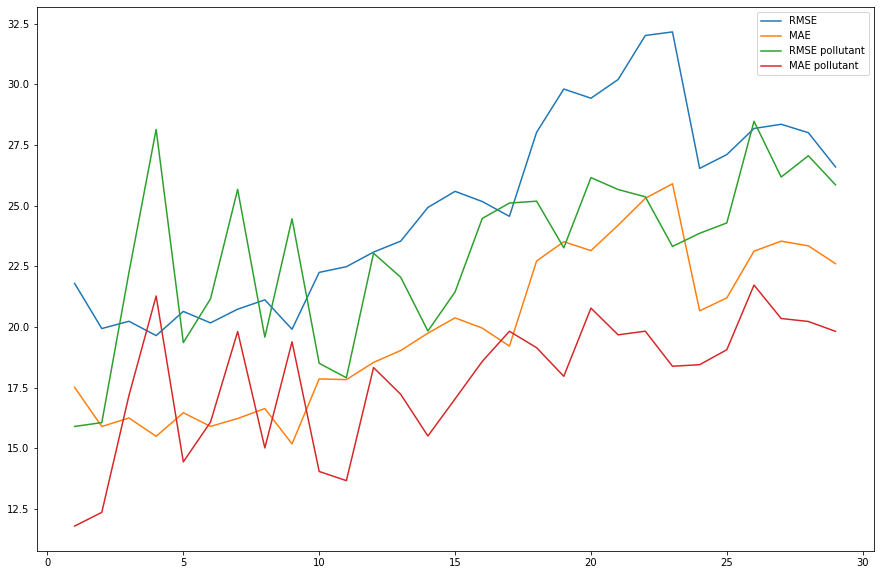

In [139]:
fig = plt.figure(figsize=(15, 10))
plt.plot([i for i in range(1, n)], error_xgb["rmse"], label="RMSE")
plt.plot([i for i in range(1, n)], error_xgb["mae"], label="MAE")
plt.plot([i for i in range(1, n)], error_xgb_pollutant["rmse"], label="RMSE pollutant")
plt.plot([i for i in range(1, n)], error_xgb_pollutant["mae"], label="MAE pollutant")
plt.legend()
plt.show()

In [140]:
params_xgb = {
    'n_estimators':[100, 500, 1000],
    'min_child_weight':[4,5],
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2, 3, 4, 6, 7, 10, 15],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
}

In [141]:
depth = 1
best_random_xgb = search_best_params(cols_pollutant, df_aqi_daily, depth, 3, params_xgb, XGBRegressor(random_state=0, verbosity = 0))
best_random_xgb.best_params_

{'subsample': 0.6,
 'objective': 'reg:squarederror',
 'n_estimators': 500,
 'min_child_weight': 4,
 'max_depth': 7,
 'learning_rate': 0.01,
 'gamma': 0.3,
 'eval_metric': 'rmse',
 'eta': 0.3,
 'colsample_bytree': 1.0,
 'booster': 'gblinear'}

In [42]:
depth = 4
rmse_xgb, mae_xgb = predict_best_model(df_aqi_daily, cols_pollutant, depth, XGBRegressor(random_state=0, **best_random_xgb.best_params_))
print("Test RMSE: %.3f" % rmse_xgb, "\nTest MAE: %.3f" % mae_xgb)

Test RMSE: 11.145 
Test MAE: 6.996


In [142]:
depth = 1
rmse_xgb, mae_xgb = predict_best_model(df_aqi_daily, cols_pollutant, depth, XGBRegressor(random_state=0, **best_random_xgb.best_params_))
print("Test RMSE: %.3f" % rmse_xgb, "\nTest MAE: %.3f" % mae_xgb)

Test RMSE: 17.583 
Test MAE: 14.037


In [38]:
depth = 1
best_best_params = {'subsample': 0.6,
 'objective': 'reg:squarederror',
 'n_estimators': 500,
 'min_child_weight': 4,
 'max_depth': 7,
 'learning_rate': 0.01,
 'gamma': 0.3,
 'eval_metric': 'rmse',
 'eta': 0.3,
 'colsample_bytree': 1.0,
 'booster': 'gblinear'}
rmse_xgb, mae_xgb = predict_best_model(df_aqi_daily, cols_pollutant, depth, XGBRegressor(random_state=0, **best_best_params))
print("Test RMSE: %.3f" % rmse_xgb, "\nTest MAE: %.3f" % mae_xgb)

Test RMSE: 11.368 
Test MAE: 7.188


In [45]:
depth = 4
best_best_params = {'subsample': 0.8,
 'objective': 'reg:squarederror',
 'n_estimators': 500,
 'min_child_weight': 5,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 0.3,
 'eval_metric': 'rmse',
 'eta': 0.3,
 'colsample_bytree': 1.0,
 'booster': 'gblinear'}
rmse_xgb, mae_xgb = predict_best_model(df_aqi_daily, cols_pollutant, depth, XGBRegressor(random_state=0, **best_best_params))
print("Test RMSE: %.3f" % rmse_xgb, "\nTest MAE: %.3f" % mae_xgb)

Test RMSE: 11.152 
Test MAE: 6.984
